In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
% matplotlib inline

In [2]:
#--------------------画像読み込み---------------------#

data_dir_path = "/Users/yukari/programing/machine_learning/kagami_tsukasa"
kagami_rel_path = "/hiiragi_kagami"
tsukasa_rel_path = "/hiiragi_tsukasa"

img_h = img_w = 160
num_classes = 2

kagami_images = []
tsukasa_images = []

def file_collect(chara_rel_path, imglis, dir_path = data_dir_path):
	chara_dir = os.listdir(dir_path+"/"+chara_rel_path)
	for file_name in chara_dir:
		_, ext = os.path.splitext(file_name)
		#print(root, ext, file_name)
		if ext != ".png" and ext != ".jpg":
			print("nyampass")
			continue
		img = cv2.imread(dir_path + "/" + chara_rel_path + "/" + file_name)
		#resize, float化, 正規化, 色空間変更
		img = cv2.resize(img, (img_h, img_w))
		img = img.astype("float32")
		img /= 255
		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
		imglis.append(img)

file_collect(kagami_rel_path, kagami_images)
file_collect(tsukasa_rel_path, tsukasa_images)

kagami_images = np.array(kagami_images)
tsukasa_images = np.array(tsukasa_images)

'''
plt.imshow(tsukasa_images[3])
plt.show()
'''


nyampass
nyampass


'\nplt.imshow(tsukasa_images[3])\nplt.show()\n'

In [3]:
#--------------------データ作成---------------------#

# listで受け取る
def make_train_test(img_arr):

	X_train = X_test = np.empty((0, img_h, img_w, 3))
	y_train = y_test = np.empty((0))

	for i, img in enumerate(img_arr):
		img_len = img.shape[0]
		#train : test = 8:2
		train_l = img_len * 8 // 10
		test_l = img_len - train_l
		X_train = np.concatenate([X_train, img[:train_l]], axis=0)
		X_test = np.concatenate([X_test, img[train_l:]], axis=0)
		y_train = np.concatenate([y_train, np.full(train_l, i)], axis=0)
		y_test = np.concatenate([y_test, np.full(test_l, i)], axis=0)

		
		print(X_train.shape, X_test.shape)
		print(y_train.shape, y_test.shape)
		
	return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = make_train_test([kagami_images, tsukasa_images])

(88, 160, 160, 3) (22, 160, 160, 3)
(88,) (22,)
(176, 160, 160, 3) (44, 160, 160, 3)
(176,) (44,)


In [4]:
from sklearn.model_selection import train_test_split
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, train_size=0.8)

/Users/yukari/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
#--------------------モデル作成---------------------#

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers import Flatten

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

model.add(Conv2D(32, input_shape=X_train[0].shape,
                 kernel_size=3,
                 strides=1,
                 padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2))

model.add(Conv2D(64,
                 kernel_size=3,
                 strides=1,
                 padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2))

model.add(Conv2D(64,
                 kernel_size=3,
                 strides=1,
                 padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

n_epoch = 50

hist=model.fit(X_train,y_train,
                 epochs=n_epoch,
                 validation_data=(X_test, y_test),verbose=1,batch_size=10)

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 176 samples, validate on 44 samples
Epoch 1/50
176/176 [==============================] - 14s - loss: 1.1712 - acc: 0.5455 - val_loss: 0.7263 - val_acc: 0.3182

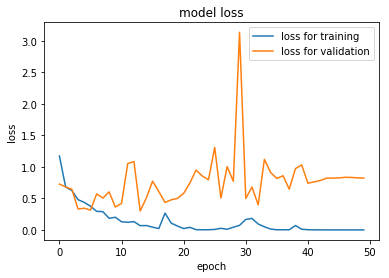

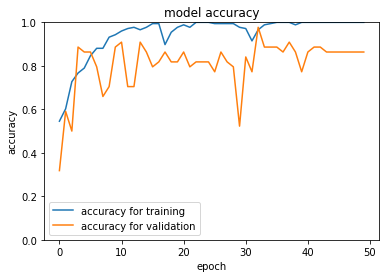

In [8]:
def plot_history_loss(hist):
    # 損失値(Loss)の遷移のプロット
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

def plot_history_acc(hist):
    # 精度(Accuracy)の遷移のプロット
    plt.plot(hist.history['acc'],label="accuracy for training")
    plt.plot(hist.history['val_acc'],label="accuracy for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

In [31]:
model.predict(kagami_images[0].reshape((1,img_h, img_w, 3))).argmax()

0

In [59]:
def plot_and_predict(model, X):
	Xin = X
	plt.imshow(Xin)
	plt.show()
	prediction = model.predict(Xin.reshape((1, img_h, img_w, 3)))
	print("prediction:{}".format(ans_dict[prediction.argmax()]))
	print("kagami :{:.3f} vs tsukasa:{:.3f}".format(prediction[0][0], prediction[0][1]))

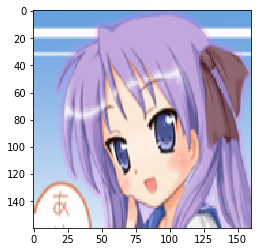

prediction:柊かがみ
kagami :1.000 vs tsukasa:0.000


In [60]:
plot_and_predict(model, kagami_images[10])

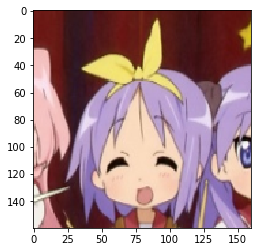

prediction:柊つかさ
kagami :0.000 vs tsukasa:1.000


In [61]:
plot_and_predict(model, tsukasa_images[98])

nyampass


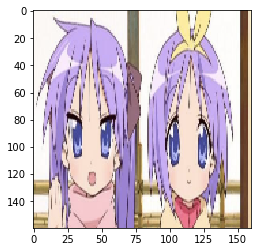

prediction:柊かがみ
kagami :1.000 vs tsukasa:0.000


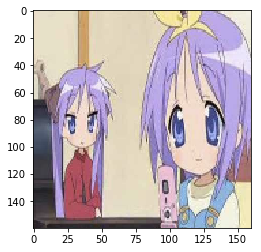

prediction:柊かがみ
kagami :0.994 vs tsukasa:0.006


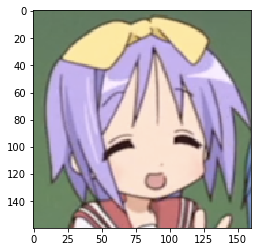

prediction:柊つかさ
kagami :0.000 vs tsukasa:1.000


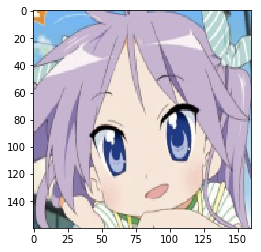

prediction:柊かがみ
kagami :0.999 vs tsukasa:0.001


In [63]:
valids = []
def valid_plt(path):
	file_collect(path, valids)
	for img in valids:
		plot_and_predict(model, img)

valid_plt("/validation")